## Import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

### Getting landscape image data,resizing them and appending in array
To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        #normalisation of pixel values
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         
   

 84%|████████▍ | 6000/7129 [00:28<00:05, 213.15it/s]


### Plotting Color image and it's corresponding grayscale image

In [3]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

**Plotting image pair**

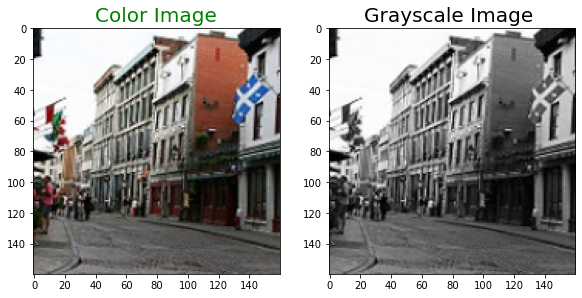

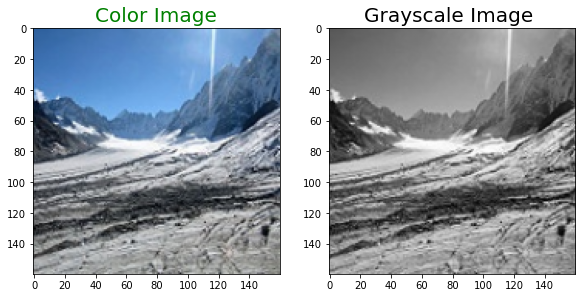

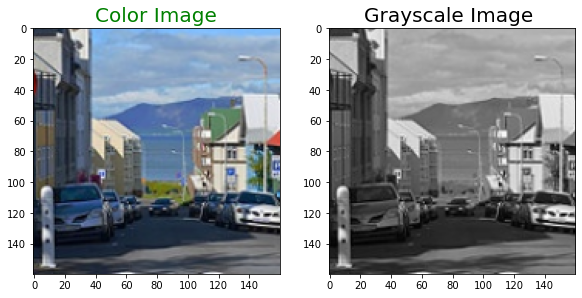

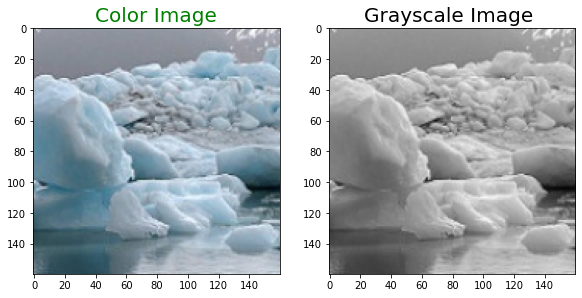

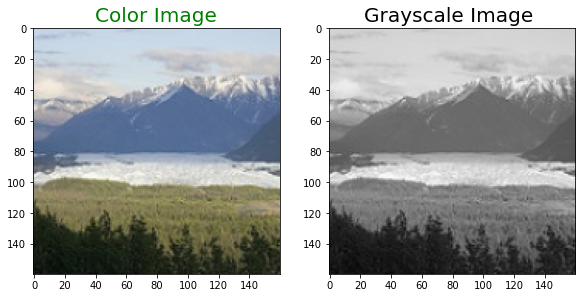

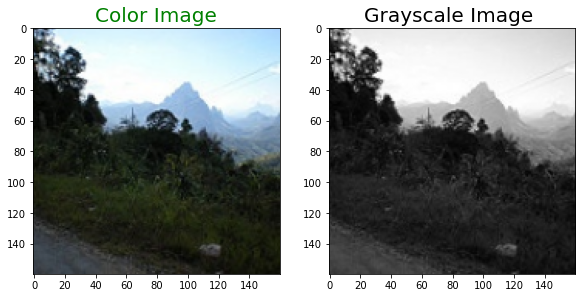

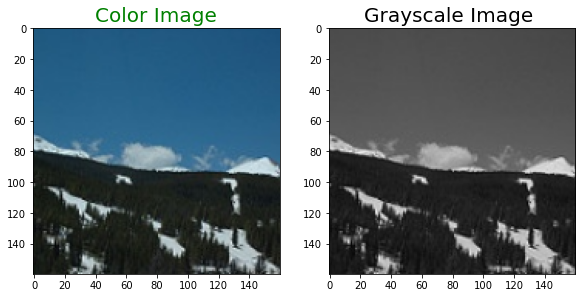

In [4]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

### Slicing and reshaping
Out of 5000 images I have sliced them to two part. train images consist 4000 images  while test images contains 1000 images.
After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [5]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


## Defining our model
Encoder layer of our model consist blocks of Convolution layer with different number of kernel and kernel_size. Here, Convolution is used for downsampling.
Similary, Decoder layer of our model consist of  transpose convolution layer with different kernel size. Here, Decoder layer upsample image downsampled by encoder.
Since there is feature loss between the encoder and decoder layers so inorder to prevent feature loss i have concatenate corresponding encoder and decoder layers. Check U_Net architecture for better understanding......

In [6]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


def model():
    x = Input(shape= [160,160,3])
    # Encoder
    conv1_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
    conv1_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
    
    conv1_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2), padding='same')(conv1_3)
         

    #upsampling
    
    
    conv2_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    up2 = UpSampling2D((2, 2))(conv2_2)
    
    conv2_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up5 = UpSampling2D((2, 2))(conv2_4)
    conv2_5 = Conv2D(3, (3, 3), activation='relu', padding='same')(up5)
    
    ret = UpSampling2D((2, 2))(conv2_5)
                
    autoencoder = Model(inputs=x, outputs=ret)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    
    
    
    return autoencoder

In [7]:
model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 256)      

### Fitting our model

In [8]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 20,batch_size = 50,verbose = 1)

Epoch 1/20
110/110 [==============================] - 13s 117ms/step - loss: 0.1370 - acc: 0.4099
Epoch 2/20
110/110 [==============================] - 13s 118ms/step - loss: 0.0898 - acc: 0.4866
Epoch 3/20
110/110 [==============================] - 13s 118ms/step - loss: 0.0859 - acc: 0.4934
Epoch 4/20
110/110 [==============================] - 13s 117ms/step - loss: 0.0817 - acc: 0.4944
Epoch 5/20
110/110 [==============================] - 13s 119ms/step - loss: 0.0794 - acc: 0.4992
Epoch 6/20
110/110 [==============================] - 13s 117ms/step - loss: 0.0788 - acc: 0.5062
Epoch 7/20
110/110 [==============================] - 13s 118ms/step - loss: 0.0776 - acc: 0.5086
Epoch 8/20
110/110 [==============================] - 13s 118ms/step - loss: 0.0756 - acc: 0.5210
Epoch 9/20
110/110 [==============================] - 13s 118ms/step - loss: 0.0754 - acc: 0.5229
Epoch 10/20
110/110 [==============================] - 13s 118ms/step - loss: 0.0738 - acc: 0.5330
Epoch 11/20
110/110

In [9]:
model.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 1s 39ms/step - loss: 0.0720 - acc: 0.5516


[0.07202700525522232, 0.5516127943992615]

# plotting colorized image along with grayscale and color image

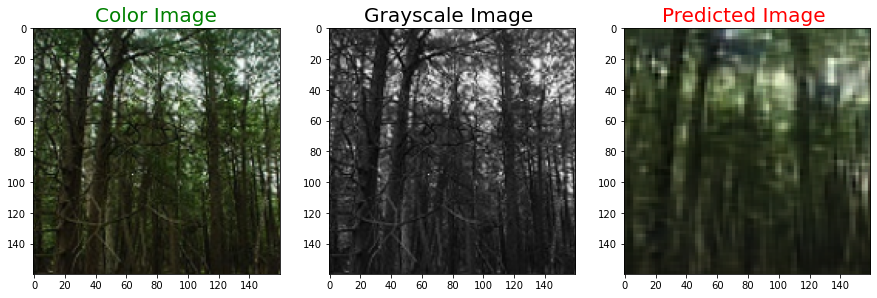

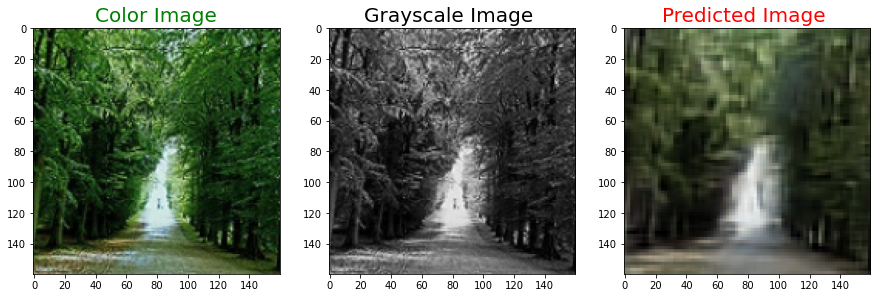

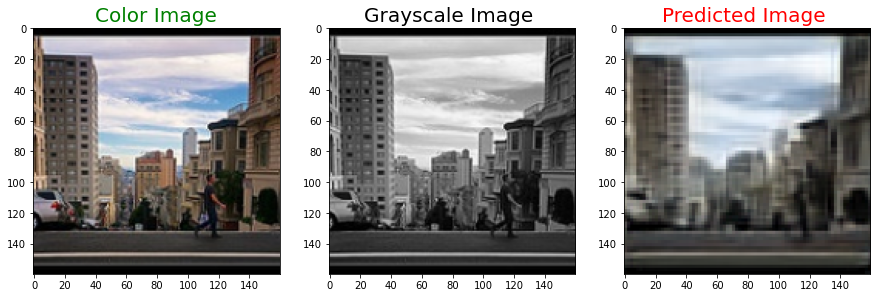

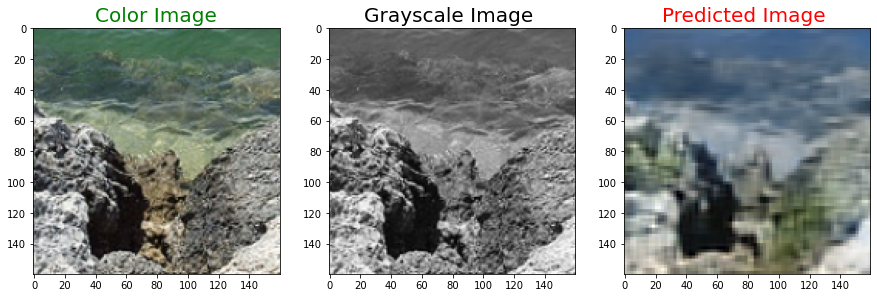

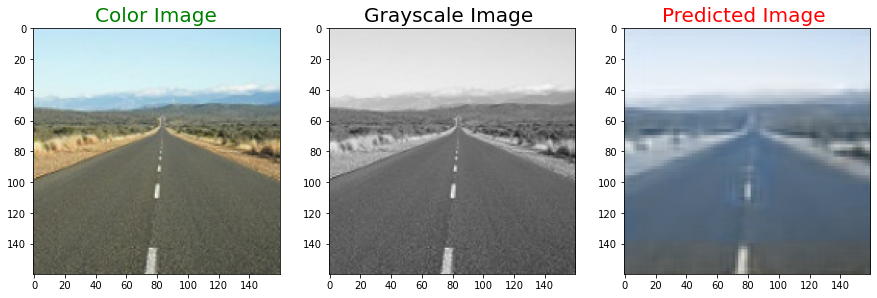

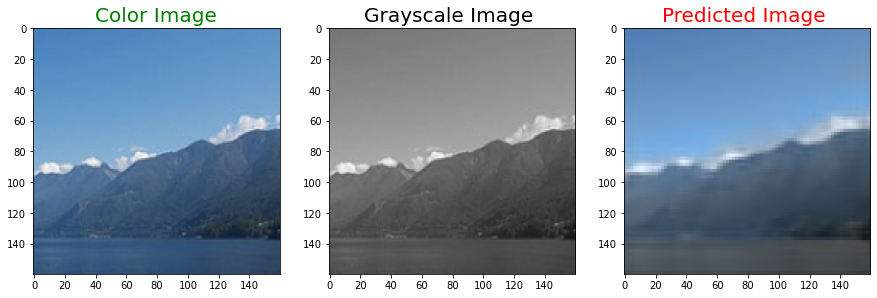

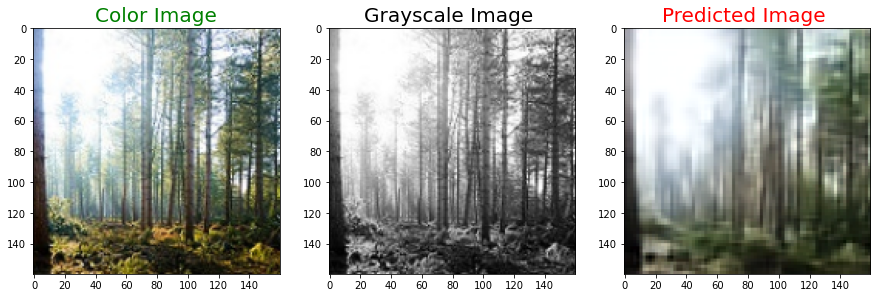

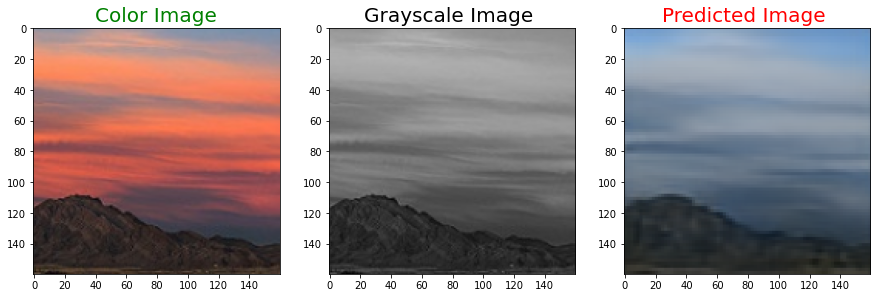

In [10]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 